# **Modelo de regresión con random forest**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [3]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [4]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

##Función de metricas

In [6]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


## Función grafica mejor

In [7]:
from sklearn.ensemble import RandomForestRegressor

def grafica_mejor(url, opc):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

  RR = RandomForestRegressor(max_depth=9, random_state=0, n_estimators=opc)
  RR.fit(X_Entrenamiento, Y_Entrenamiento)

  Y_pred = RR.predict(X_Prueba)


  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión basada en random forest') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión basada en random forest') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

##Función de guardadado de resultados

In [8]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);

##Medianos

In [9]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [10]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/random_forest.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data

      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
        estimadores = [20, 40, 60, 80, 100]

        for opc in estimadores:
          RR = RandomForestRegressor(max_depth=9, random_state=0, n_estimators=opc)
          RR.fit(X_Entrenamiento, Y_Entrenamiento)

          Y_pred = RR.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, RR, filename)
          result['CONFIG'] = opc
          df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [11]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
558,min_max_isf_400_0_2.csv,80,0.882498,-0.000008,8.668667e-07,0.864358,0.023085,0.882506,0.001543,0.020769,1.043576
559,min_max_isf_400_0_2.csv,100,0.882337,-0.000008,8.568142e-07,0.864652,0.022928,0.882345,0.001543,0.020241,1.029158
557,min_max_isf_400_0_2.csv,60,0.882288,-0.000008,8.657822e-07,0.863846,0.022990,0.882296,0.001544,0.020227,0.982944
556,min_max_isf_400_0_2.csv,40,0.881761,-0.000008,9.113319e-07,0.863417,0.022766,0.881768,0.001545,0.021096,0.813888
555,min_max_isf_400_0_2.csv,20,0.880075,-0.000008,8.334840e-07,0.862385,0.023383,0.880085,0.001552,0.020194,0.739812
481,min_max_isf_100_0_2.csv,40,0.880696,-0.000009,5.973486e-07,0.866121,0.018015,0.880711,0.001560,0.014953,0.464127
482,min_max_isf_100_0_2.csv,60,0.881093,-0.000009,5.573987e-07,0.866124,0.017698,0.881105,0.001560,0.014947,0.574869
480,min_max_isf_100_0_2.csv,20,0.879832,-0.000009,6.050863e-07,0.865156,0.017566,0.879859,0.001560,0.015148,0.818675
483,min_max_isf_100_0_2.csv,80,0.881188,-0.000009,5.311951e-07,0.866183,0.017751,0.881203,0.001561,0.014963,0.464565
484,min_max_isf_100_0_2.csv,100,0.881102,-0.000009,5.412832e-07,0.866089,0.017615,0.881116,0.001562,0.014975,0.418477


### Mejor resultado

In [12]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
558,min_max_isf_400_0_2.csv,80,0.882498,-0.000008,8.668667e-07,0.864358,0.023085,0.882506,0.001543,0.020769,1.043576


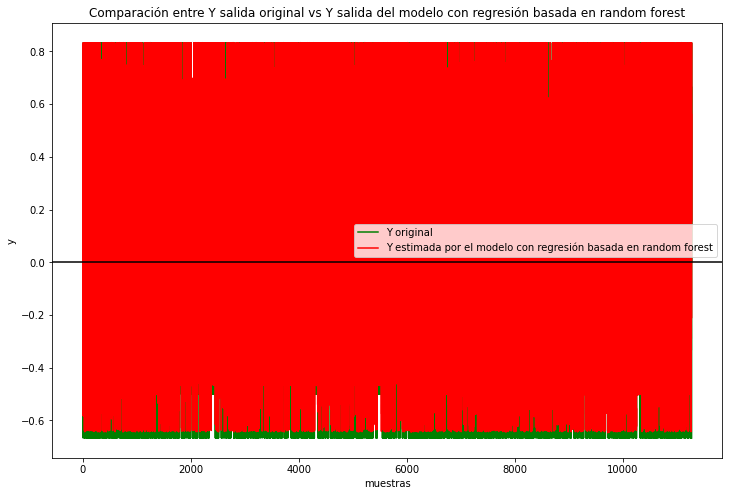

In [13]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']
opc = df_resultados_medianos_sort.at[0,'CONFIG']
grafica_mejor(url, opc)

## Grandes

In [14]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/random_forest.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data

      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
        estimadores = [20, 40, 60, 80, 100]

        for opc in estimadores:
          RR = RandomForestRegressor(max_depth=9, random_state=0, n_estimators=opc)
          RR.fit(X_Entrenamiento, Y_Entrenamiento)

          Y_pred = RR.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, RR, filename)
          result['CONFIG'] = opc
          df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [15]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
154,min_max_lof_manhattan_5.csv,100,0.973404,-0.000041,0.000023,0.959706,0.028319,0.973404,0.001003,0.000754,14.667231
152,min_max_lof_manhattan_5.csv,60,0.974021,-0.000041,0.000023,0.960722,0.027018,0.974021,0.001004,0.000606,0.937795
153,min_max_lof_manhattan_5.csv,80,0.973406,-0.000041,0.000023,0.959814,0.028093,0.973406,0.001004,0.000750,11.550295
151,min_max_lof_manhattan_5.csv,40,0.973053,-0.000041,0.000023,0.960409,0.027950,0.973054,0.001011,0.000614,1.128173
150,min_max_lof_manhattan_5.csv,20,0.973313,-0.000042,0.000023,0.959582,0.029106,0.973313,0.001012,0.000605,1.065993
142,min_max_lof_euclidean_5.csv,60,0.964394,-0.000047,0.000018,0.951149,0.033550,0.964395,0.001022,0.001050,3.456511
147,min_max_lof_minkowski_5.csv,60,0.964394,-0.000047,0.000018,0.951149,0.033550,0.964395,0.001022,0.001050,3.456511
141,min_max_lof_euclidean_5.csv,40,0.965167,-0.000049,0.000018,0.949220,0.033917,0.965169,0.001023,0.001012,1.558455
146,min_max_lof_minkowski_5.csv,40,0.965167,-0.000049,0.000018,0.949220,0.033917,0.965169,0.001023,0.001012,1.558455
143,min_max_lof_euclidean_5.csv,80,0.964212,-0.000046,0.000017,0.950716,0.033611,0.964213,0.001024,0.001051,4.482694


### Mejor resultado

In [16]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
154,min_max_lof_manhattan_5.csv,100,0.973404,-0.000041,0.000023,0.959706,0.028319,0.973404,0.001003,0.000754,14.667231


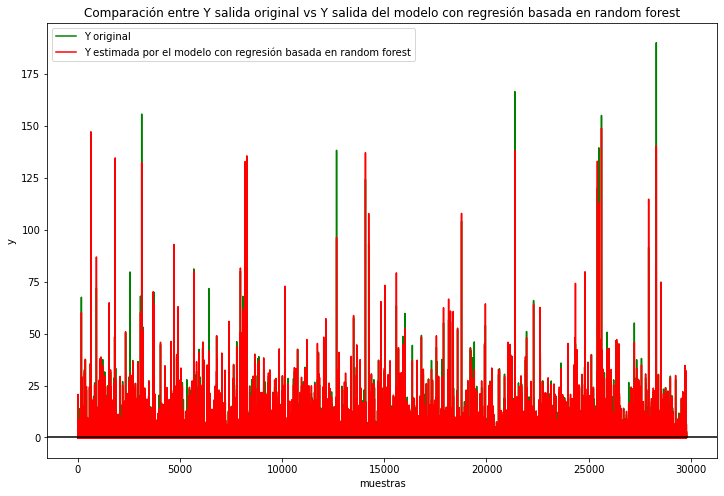

In [17]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']
opc = df_resultados_grandes_sort.at[0,'CONFIG']

grafica_mejor(url, opc)